In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import aix360.algorithms.rbm
from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BooleanRuleCG

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics

from pyeda.inter import *

# ignore warning related to deprecated modules inside packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# train with fixed seed to eliminate different results
np.random.seed(777)

In [2]:
data = pd.read_csv("../datasets/Placement_Data_Full_Class.csv",
                    dtype={"sl_no": int,
                            "gender": 'category',
                            "ssc_p" : float,
                            "ssc_b" : 'category',
                            "hsc_p" : float,
                            "hsc_b" : 'category',
                            "hsc_s" : 'category',
                            "degree_p" : float,
                            "degree_t" : 'category',
                            "workex" : 'category',
                            "etest_p" : float,
                            "specialisation" : 'category',
                            "mba_p" : float,
                            "status" : 'category',
                            "salary" : float
                           })


In [3]:
import random
import string

class LogicalOrdinalValue:
    class Term:
        def __init__(self, expr):
            parts = expr.split()
            if len(parts) != 3:
                raise ValueError
        
            self.value = float(parts[2])
            self.op = parts[1]
            self.attr = parts[0]
            
        def get_expr(self):
            return f"{self.attr} {self.op} {self.value}"
            
            
    def __init__(self, expr, landmarks):
        if(expr.split()[0] not in landmarks.keys()):
            self.term = expr
            self.type = "categorical"
            self.logical_v = None
            self.le = self.name_cat_value(expr)
        else:
            self.term = self.Term(expr)
            self.type = "ordinal"
            self.logical_v = self.v(self.term, landmarks[self.term.attr]).astype(int)
            self.le = f"{self.term.attr}_{self.v2bin(self.logical_v)}"
        
    def v(self, term, landmark):
        value = term.value
        op = term.op
        #ezen meg mindig kell dolgozni....
        result = np.zeros(19)
        for i, thr in enumerate(landmark):
            if op == ">":
                if value < landmark[i]:
                    result[i] = 1
            elif op == "<=":
                if value >= landmark[i]:
                    result[i] = 1
            else: # =
                if value < landmark[i] and i != 0:
                    result[i-1] = 1
                    break
                    
        return result
    
    def v2bin(self, arr):
        return np.sum((2 ** np.arange(arr.shape[0])) * arr ).astype(int)
    
    def name_cat_value(self, expr):
        # naming: attr_c_[in]v
        parts = expr.split()
        op = "i" if len(parts) > 1 and (parts[1] == "==" or parts[1] == "not") else "n"
        if len(parts) == 3:
            c = parts[2].translate(str.maketrans('','',string.punctuation))
        else:
            c = "0"
        return f"{parts[0]}_c_{op}{c}"

In [4]:
class TransformLogical:
    def __init__(self, ruleset, landmark):
        self.landmark = landmark
        self.transformed_rules = []
        for rule in ruleset:
            terms = rule.split(" AND ")
            self.transformed_rules.append([LogicalOrdinalValue(term, landmark) for term in terms])
                
                
    def get_expr(self):
        result = ""
        for rule in self.transformed_rules:
            for terms in rule:
                result += terms.le
                result += " & "
            result = result.rstrip(" & ")
            result += " | "
        return result.rstrip(" | ")
    
    
    def add_ord_impl(self, x, y, const_list):
        dim = len(x.logical_v)
        x_and_y = np.bitwise_and(x.logical_v, y.logical_v)
        mask = np.zeros(dim).astype(int)
        mask[0] = 1
        mask[-1] = 1
        if np.count_nonzero(x_and_y) == 0:
            const_list.append(expr(f"{x.le} <=> ~ {y.le}"))
        elif np.count_nonzero(np.bitwise_and(x_and_y, mask)) != 0:
            if x.v2bin(x.logical_v) < y.v2bin(y.logical_v):
                const_list.append(expr(f"{x.le} => {y.le}"))
        
    
    def make_constraints(self):
        cat_constraints = dict()
        ord_constraints = []
        flat_rules = list(np.concatenate(self.transformed_rules).flat)
        # could be n*logn
        for x in flat_rules:
            if x.type == "categorical":
                attr = x.term.split()[0]
                op = x.le.split('_')[-1].startswith("i")
                if op:
                    if attr not in cat_constraints:
                        cat_constraints[attr] = list()
                    cat_constraints[attr].append(x.le)
            else:
                for y in flat_rules:
                    if y.type == "ordinal" and x.term.attr == y.term.attr and x != y:
                        self.add_ord_impl(x, y, ord_constraints)
                    
        onehot_list = []
        for onehot in cat_constraints.values():
            if len(onehot) > 1:
                onehot_list.append(OneHot0(*onehot))
            
        onehot_expr = And(*onehot_list)
        impl_expr = And(*ord_constraints)
        return And(onehot_expr, impl_expr)
    
    
    def get_expr_w_constraints(self):
        main_expr = expr(self.get_expr())
        constraints = self.make_constraints()
        return And(main_expr, constraints)
        

In [5]:
complex_9_dnf = ['ssc_p > 67.00', 
 'ssc_p > 52.00 AND ssc_b not  AND workex  ', 
 'gender   AND ssc_p > 62.00 AND hsc_p > 67.52', 
 'hsc_p > 65.00 AND hsc_s != Commerce AND degree_p > 69.58', 
 'ssc_p > 58.00 AND hsc_p > 52.00 AND hsc_s != Science AND mba_p <= 60.40', 
 'hsc_p <= 67.52 AND hsc_p > 52.00 AND etest_p <= 75.00 AND mba_p <= 54.99', 
 'hsc_p > 52.00 AND degree_p <= 77.12 AND degree_p > 65.00 AND degree_t == Comm&Mgmt AND etest_p <= 92.00 AND mba_p <= 70.68']

complex_19_dnf = ['ssc_p > 73.00 AND hsc_p > 65.00', 
 'ssc_p > 55.00 AND degree_p > 61.00 AND specialisation not ', 
 'hsc_p > 52.00 AND degree_p > 65.00 AND mba_p <= 66.25', 
 'ssc_p > 52.00 AND ssc_b not  AND workex  ', 
 'ssc_p > 67.00 AND ssc_b   AND hsc_p <= 60.90', 'gender   AND ssc_p > 64.00 AND etest_p > 92.00', 
 'ssc_p > 52.00 AND hsc_p > 57.00 AND etest_p <= 75.00 AND etest_p > 54.34 AND mba_p <= 59.47']
middle_dnf_desc = ['ssc_p > 64.00 AND hsc_p > 65.00', 
                   'ssc_p > 52.00 AND hsc_p > 52.00 AND degree_t != Sci&Tech AND mba_p <= 58.78',
                'ssc_p > 32.00 AND degree_t != Sci&Tech']

In [6]:
categorical_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
X = data.drop(columns=["sl_no", "status", "salary"])

fb_19 = FeatureBinarizer(numThresh=19, colCateg=categorical_features, negations=True, returnOrd=True)
X_bin_19, X_std = fb_19.fit_transform(X)

In [7]:
c1 = TransformLogical(complex_9_dnf, fb_19.thresh)
c2 = TransformLogical(complex_19_dnf, fb_19.thresh)
m1 = TransformLogical(middle_dnf_desc, fb_19.thresh)

In [8]:
Xor(expr(c1.get_expr(), simplify=True), expr(c2.get_expr(), simplify=True), simplify=True)

Xor(Or(ssc_p_523264, And(ssc_p_524284, ssc_b_c_i0, workex_c_n0), And(gender_c_n0, ssc_p_524224, hsc_p_522240), And(hsc_p_523264, hsc_s_c_nCommerce, degree_p_126976), And(ssc_p_524272, hsc_p_524284, hsc_s_c_nScience, mba_p_127), And(hsc_p_524284, hsc_p_2047, etest_p_4095, mba_p_3), And(hsc_p_524284, degree_p_65535, degree_p_130816, degree_t_c_iCommMgmt, etest_p_262143, mba_p_262143)), Or(And(hsc_p_523264, ssc_p_516096), And(ssc_p_524280, degree_p_131040, specialisation_c_i0), And(hsc_p_524284, degree_p_130816, mba_p_16383), And(ssc_p_524284, ssc_b_c_i0, workex_c_n0), And(ssc_p_523264, ssc_b_c_n0, hsc_p_31), And(gender_c_n0, ssc_p_524032, etest_p_262144), And(ssc_p_524284, mba_p_127, etest_p_4095, hsc_p_524280, etest_p_524286)))

In [9]:
import sys
sys.executable

'/Users/hainb/miniconda3/envs/aix360/bin/python'

In [10]:
!/Users/hainb/miniconda3/bin/python -m pip install gvmagic

You should consider upgrading via the '/Users/hainb/miniconda3/bin/python -m pip install --upgrade pip' command.


In [11]:
import gvmagic
%load_ext gvmagic

In [12]:
bdd1 = expr2bdd(c1.get_expr_w_constraints())
bdd2 = expr2bdd(c2.get_expr_w_constraints())
bdd3 = expr2bdd(m1.get_expr_w_constraints())

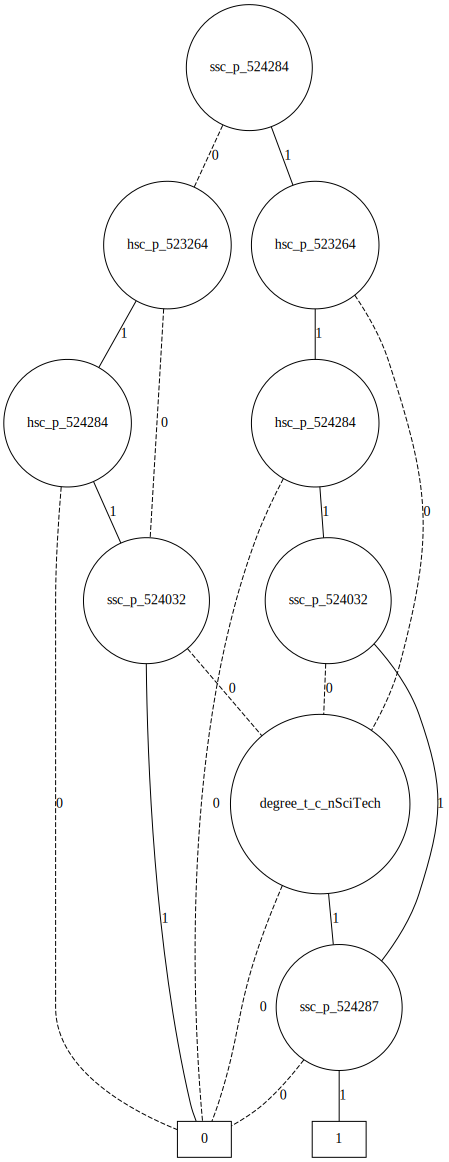

In [13]:
%dotobj bdd3

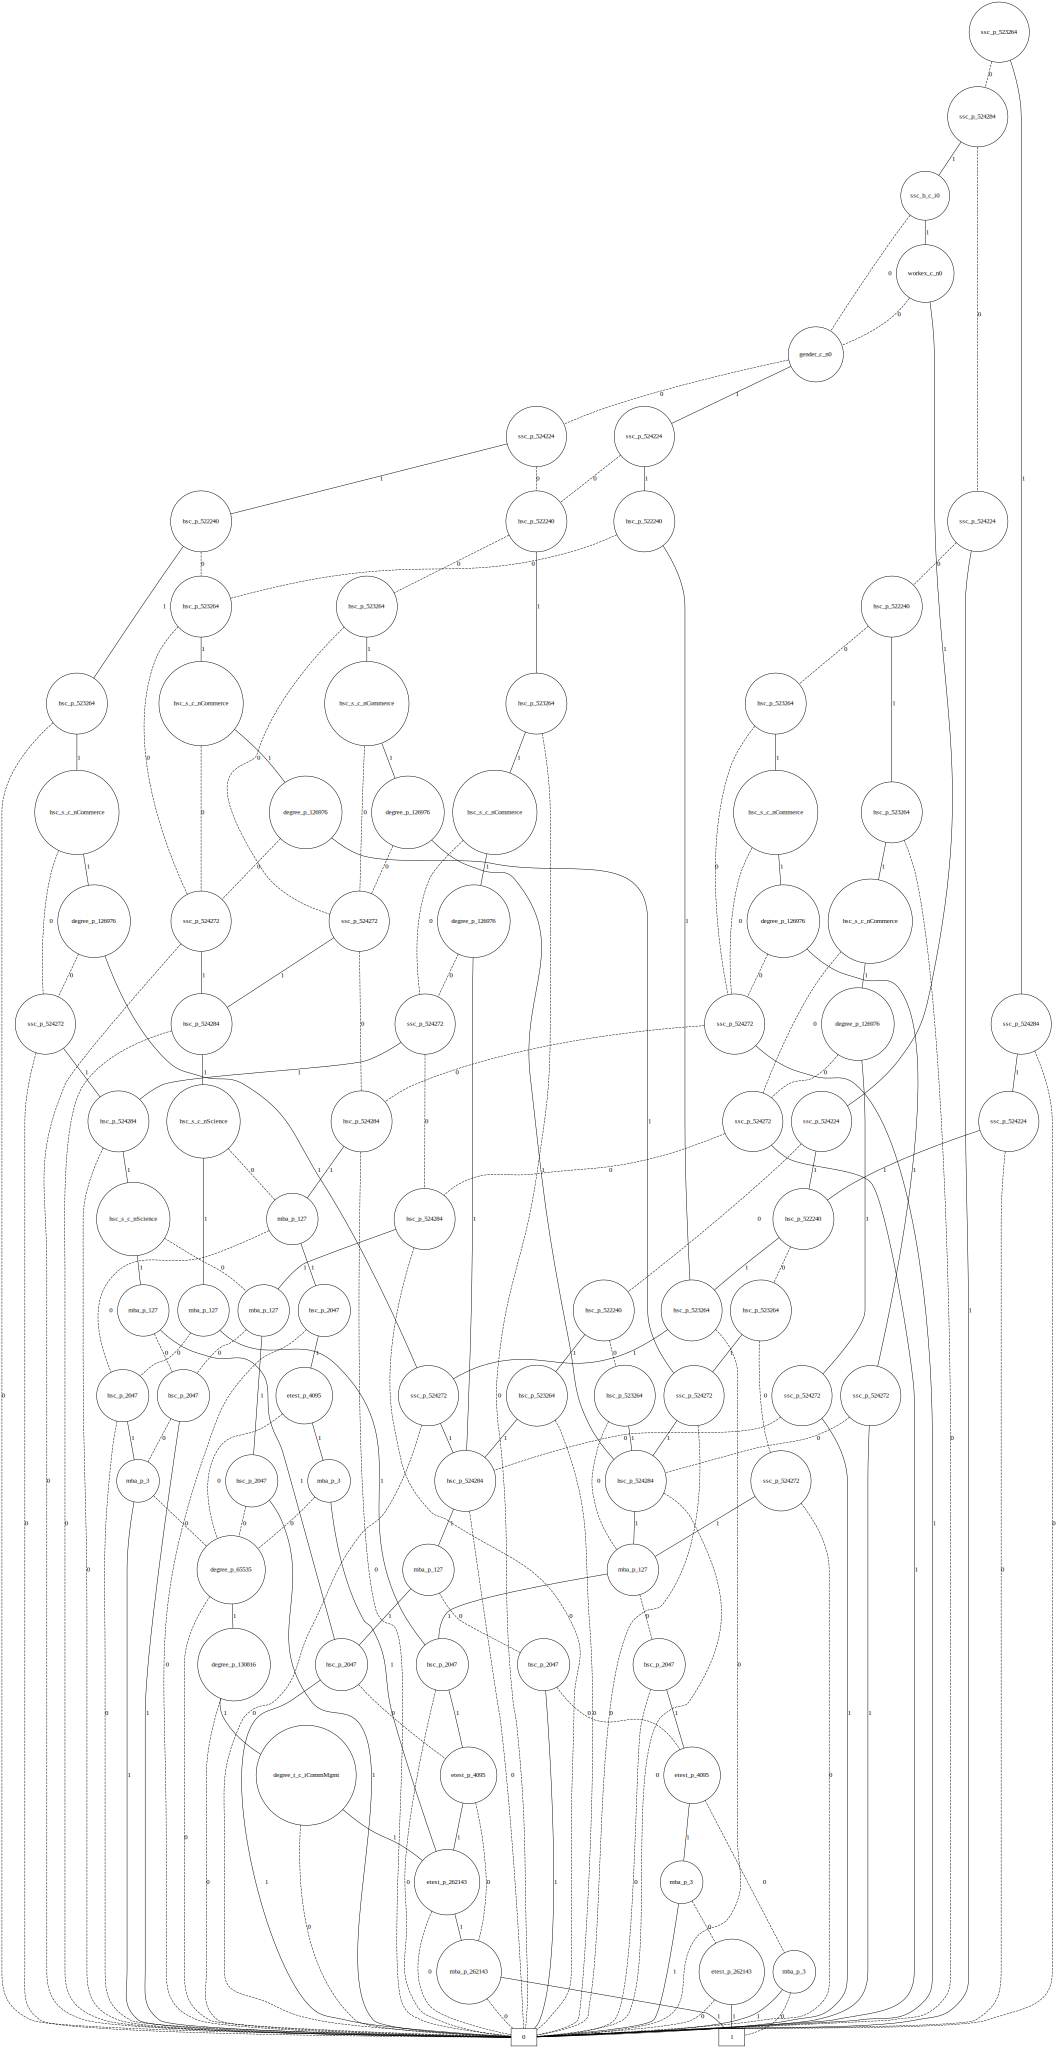

In [14]:
%dotobj bdd1

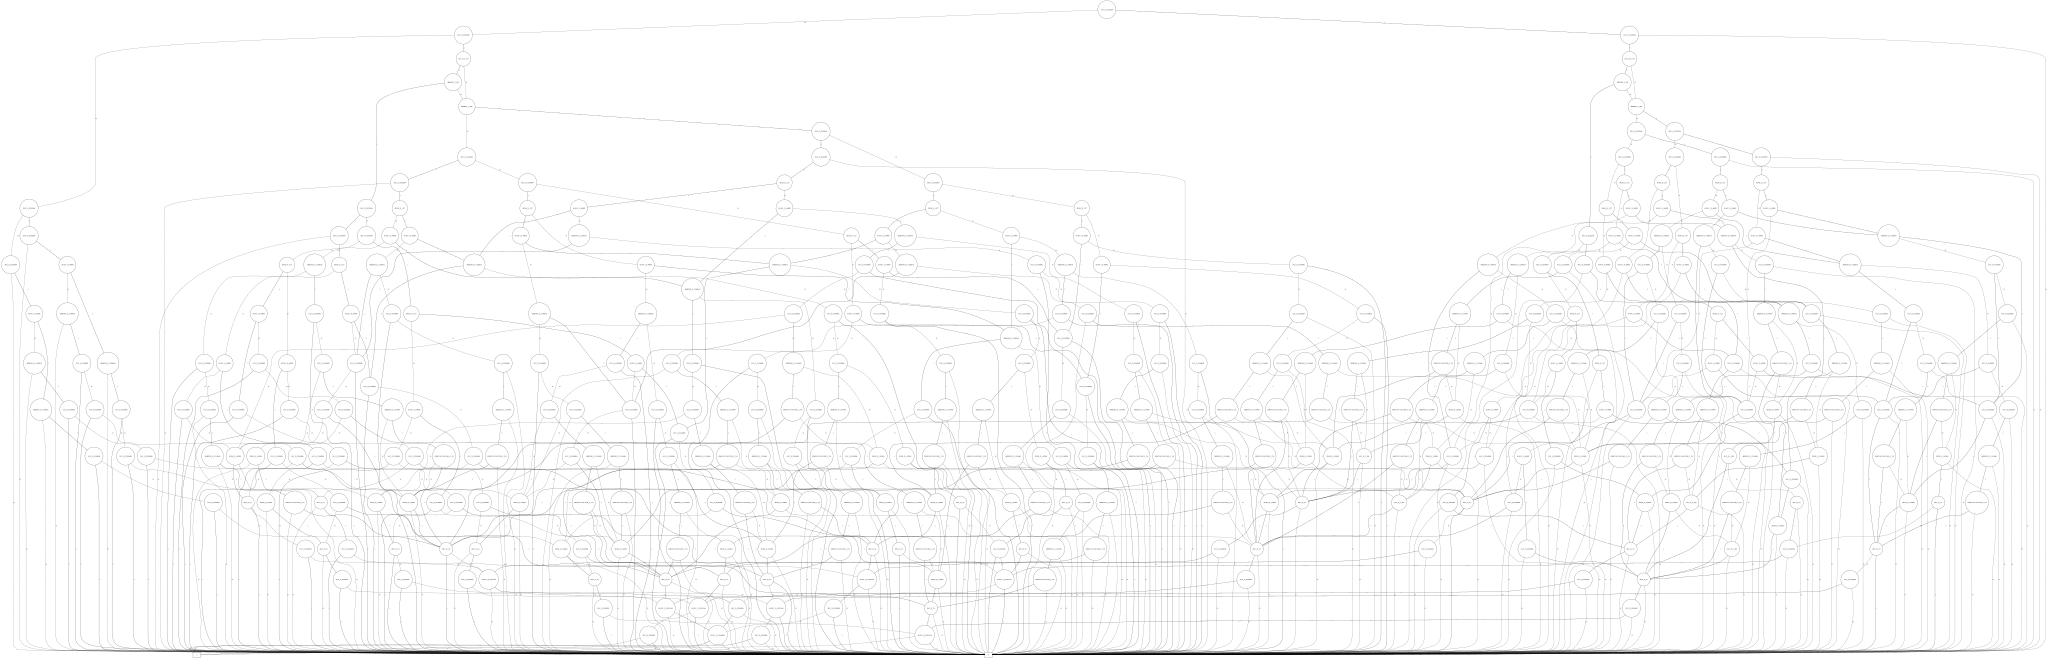

In [15]:
%dotobj bdd2